<a href="https://colab.research.google.com/github/keran-w/Smile_Detection/blob/main/Colabs/ProjML%26AI_Final_Project_RGB_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile Detection ViT

### Setup

In [ ]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 20
seed_everything(SEED)

In [ ]:
!pip install transformers
clear_output()

In [ ]:
!pip install torchfile
!mkdir saved_models
!wget https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
!tar xf vgg_face_torch.tar.gz -C saved_models
clear_output()

### Data Collection

Data Source:
1. https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
2. https://www.kaggle.com/datasets/ghousethanedar/smiledetection
3. https://www.kaggle.com/datasets/shroukmansour/smile-detection-ass


In [ ]:
# import dataset from kaggle
import os
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d chazzer/smiling-or-not-face-data
!kaggle datasets download -d ghousethanedar/smiledetection
!kaggle datasets download -d shroukmansour/smile-detection-ass
!unzip smiling-or-not-face-data.zip -d .
!unzip smiledetection.zip -d .
!unzip smile-detection-ass.zip -d .
clear_output()
! cp -a ./datasets/test_folder/0/* ./non_smile
! cp -a ./datasets/test_folder/1/* ./smile
! cp -a ./datasets/train_folder/0/* ./non_smile
! cp -a ./datasets/train_folder/1/* ./smile
! cp -a ./'Smile Detection'/negatives_No_Smile/* ./non_smile
! cp -a ./'Smile Detection'/positives_Smile/* ./smile

In [ ]:
# Data preprocessing
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')

non_smile_paths = ['non_smile/' + filename for filename in os.listdir('non_smile')]
smile_paths = ['smile/' + filename for filename in os.listdir('smile')]

images = np.r_[smile_paths, non_smile_paths]
labels = np.r_[np.ones(len(smile_paths)), np.zeros(len(non_smile_paths))].astype('int')
label_map = {0: 'non_smile', 1: 'smile'}
data_df = pd.DataFrame({'image': images, 'label': labels})
# data_df.label.hist()
# plt.show()
data_df

,image,label
0,smile/7075.jpg,1
1,smile/2439.jpg,1
2,smile/9196.jpg,1
3,smile/Krishna_Bhadur_Mahara_0001.jpg,1
4,smile/12132.jpg,1
...,...,...
18363,non_smile/13034.jpg,0
18364,non_smile/4747.jpg,0
18365,non_smile/1077.jpg,0
18366,non_smile/7216.jpg,0


Exploratory Data Analysis

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def display_batch(images, batch_size=32, transform=None, mode='RGB', seed=20):
    assert mode in ('RGB', 'L')
    np.random.seed(seed)
    sample_idx = np.random.choice(len(images), batch_size)
    rows = len(sample_idx) // 8
    figure, ax = plt.subplots(nrows=rows, ncols=8, figsize=(20, batch_size // rows))

    for i, idx in enumerate(sample_idx):
        image, label = images[idx], labels[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB 
                             if mode == 'RGB' else cv2.COLOR_BGR2GRAY)
        if transform:
            image = Image.fromarray(transform(image=image)['image'], 
                                    'RGB' if mode == 'RGB' else 'L')
        ax.ravel()[i].imshow(image)
        title = f'{label_map[labels[idx].item()]}({labels[idx]})'
        ax.ravel()[i].set_title(title)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

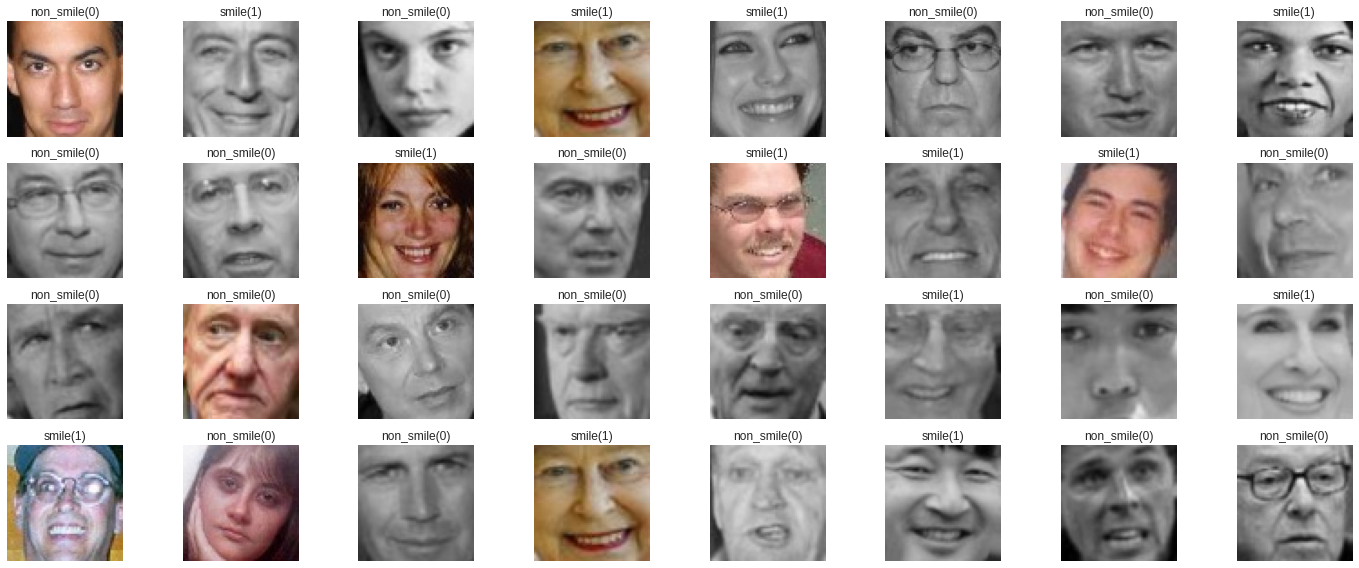

In [ ]:
# Random subset visualization -- RGB
display_batch(images, mode='RGB')

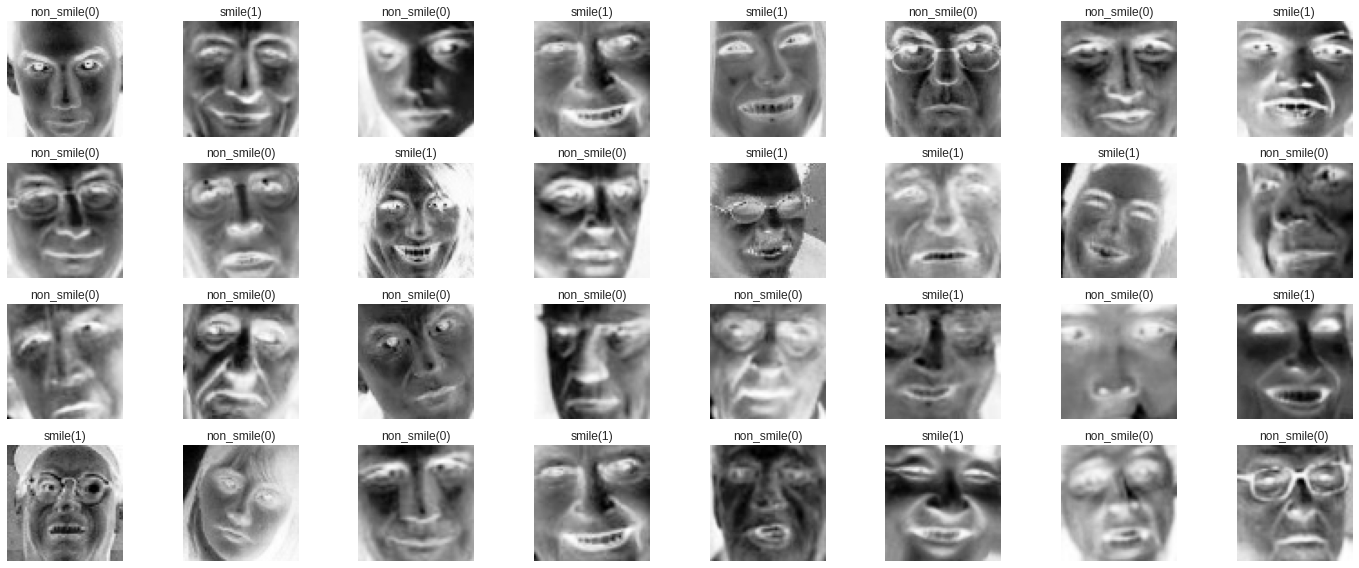

In [ ]:
# Random subset visualization -- Grayscale
display_batch(images, mode='L')

In [ ]:
# Split train and valid set
valid_size = 0.15
valid_idx = np.random.choice(len(images), int(len(images) * valid_size))
train_idx = [idx for idx in range(len(images)) if idx not in valid_idx]
train_images, train_labels, valid_images, valid_labels = \
images[train_idx], labels[train_idx], images[valid_idx], labels[valid_idx]

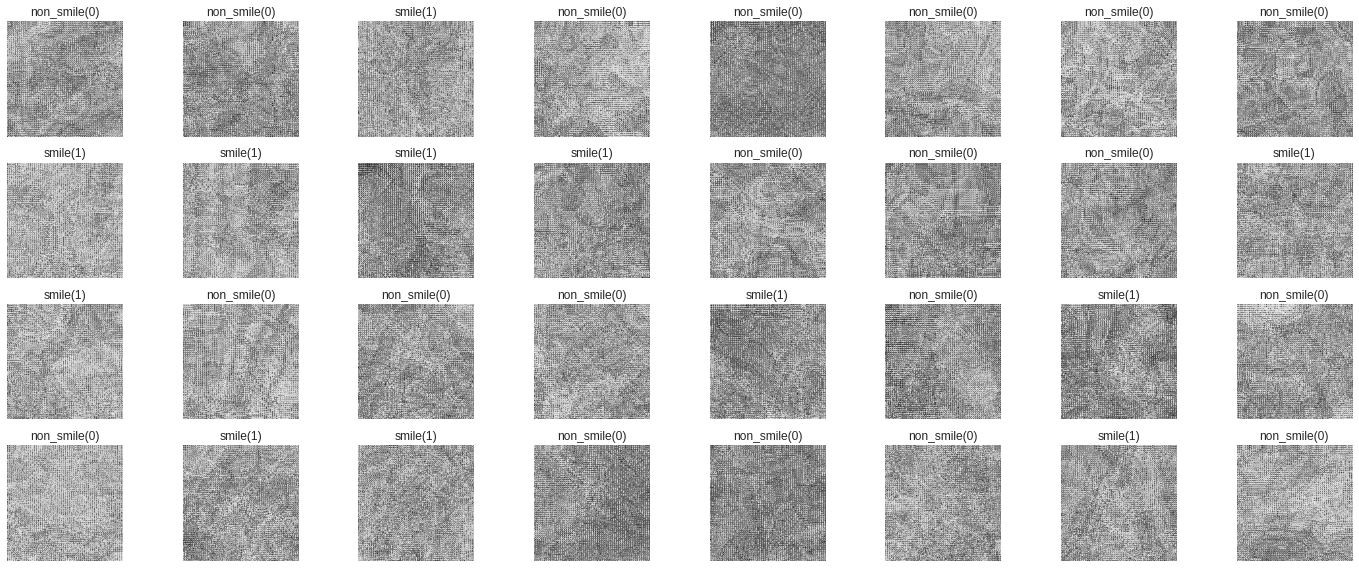

In [ ]:
# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
prob = 0.5
train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=prob),
    A.VerticalFlip(prob),
    A.Normalize(0.449, 0.226)
])

valid_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(0.449, 0.226)
])

# Random subset visualization -- Grayscale with transform
display_batch(train_images, mode='L', transform=train_transform)

In [ ]:
# Build custom dataset
import cv2

class SmileDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, mode, feature_extractor, transform=None):
        self.labels = labels
        self.images = images
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, index):
        # image = Image.open(self.images[index])
        image = cv2.imread(self.images[index])
        if self.transform is not None:
            image = np.array(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = Image.fromarray(train_transform(image=image)['image'], 'RGB')
        image = self.feature_extractor(image, return_tensors='pt')['pixel_values'][0]
        item = {'image': image, 'mode':self.mode}
        if self.labels is not None:
            item['label'] = self.labels[index]
        return item

def get_loader(images, labels, mode, transform, feature_extractor, batch_size, shuffle):
    return torch.utils.data.DataLoader(SmileDataset(images, labels, mode, feature_extractor, transform), batch_size=batch_size, shuffle=shuffle)

batch_size = 32
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
train_loader = get_loader(train_images, train_labels, 'train', train_transform, feature_extractor, batch_size, True)
valid_loader = get_loader(valid_images, valid_labels, 'valid', valid_transform, feature_extractor, batch_size, False)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# Get a sample batch
sample_batch = next(iter(train_loader))
print('Attributes:', ', '.join(list(sample_batch.keys())))
print('Batch image shape:', sample_batch['image'].shape)
print('Batch label shape:', sample_batch['label'].shape)

Attributes: image, mode, label
Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])


### Modelling

In [ ]:
#@title VIT-ARCFACE
# Build model structure
from transformers import get_cosine_schedule_with_warmup
from torch import optim, nn
from torch.nn import functional as F

class ArcFace(nn.Module):
    
    def __init__(self,in_features,out_features, margin = 0.5 ,scale = 20):
        super(ArcFace, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weights = nn.Parameter(torch.FloatTensor(out_features,in_features))
        nn.init.xavier_normal_(self.weights)
        
    def forward(self,features,targets):
        cos_theta = F.linear(F.normalize(features), F.normalize(self.weights), bias=None) 
        cos_theta = cos_theta.clip(-1, 1)
        
        arc_cos = torch.acos(cos_theta)
        M = F.one_hot(targets, num_classes = self.out_features) * self.margin
        arc_cos = arc_cos + M
        
        cos_theta_2 = torch.cos(arc_cos)
        logits = cos_theta_2 * self.scale
        return logits

class Model(torch.nn.Module):
    def __init__(self, vit_model, feature_extractor, num_labels):

        super(Model, self).__init__()
        self.vit = vit_model
        self.feature_extractor = feature_extractor
        self.num_labels = num_labels
        self.arcface = ArcFace(768, num_labels, margin=0.3)
    
    def forward(self, batch, device):
        outputs = self.vit(batch['image'].to(device))
        last_hidden_state = outputs.last_hidden_state[:,0,:]
        if batch['mode'] == 'train':
            return self.arcface(last_hidden_state)
        else:
            return F.linear(F.normalize(last_hidden_state), F.normalize(self.arcface.weights))

class FocalLoss(nn.Module):
    'Focal Loss - https://arxiv.org/abs/1708.02002'
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

from transformers import ViTModel
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Define hyperparameters
n_epoch = 10
learning_rate = 1e-4
weight_decay = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Initialize model, criterion, optimizer and scheduler
model = Model(vit_model, feature_extractor, len(set(labels))).to(device)
criterion = FocalLoss(2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=int(len(train_loader)*n_epoch*1.2))

In [ ]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, scheduler, device):
    optimizer.zero_grad()
    logits = model(batch, device)
    true_labels = batch['label'].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch, device).detach()
    true_labels = batch['label'].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, scheduler, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, scheduler, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc )
        print(f'[ {epoch+1:02d}|{n_epoch} ] avg_train_loss={avg_train_loss:.3f}, valid_acc={avg_valid_acc:.3f}')
    return avg_train_loss_list, avg_valid_acc_list

avg_train_loss_list, avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, scheduler, device)

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 00|10 ] avg_train_loss=0.135, valid_acc=0.654


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 01|10 ] avg_train_loss=0.113, valid_acc=0.700


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 02|10 ] avg_train_loss=0.103, valid_acc=0.741


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 03|10 ] avg_train_loss=0.085, valid_acc=0.758


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 04|10 ] avg_train_loss=0.082, valid_acc=0.768


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 05|10 ] avg_train_loss=0.076, valid_acc=0.779


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 06|10 ] avg_train_loss=0.070, valid_acc=0.756


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 07|10 ] avg_train_loss=0.064, valid_acc=0.760


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 08|10 ] avg_train_loss=0.061, valid_acc=0.777


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

[ 09|10 ] avg_train_loss=0.061, valid_acc=0.780


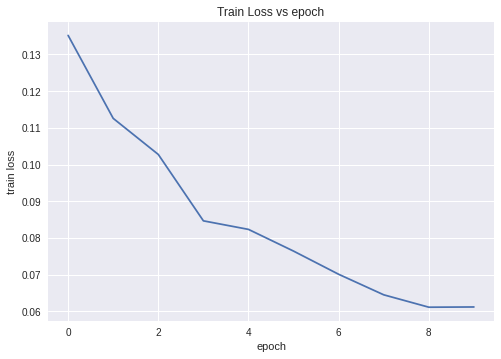

In [ ]:
# Visualize train loss 
plt.plot(avg_train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('Train Loss vs epoch')
plt.show()

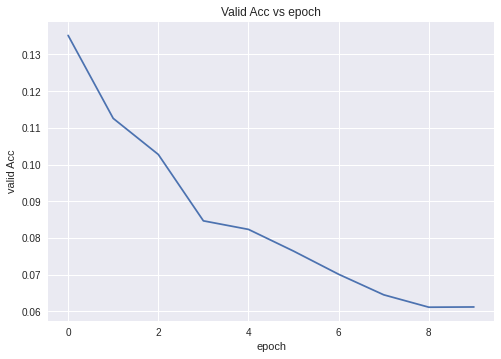

In [ ]:
# Visualize valid accuracy 
plt.plot(avg_train_loss_list)
plt.xlabel('epoch')
plt.ylabel('valid Acc')
plt.title('Valid Acc vs epoch')
plt.show()

In [ ]:
# save model for inference
torch.save(model, 'drive/MyDrive/Datasets/smile_detection/saved_models/vit_inference.pt')

In [ ]:
# save model checkpoint
torch.save({
            'epoch': n_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'drive/MyDrive/Datasets/smile_detection/saved_models/vit_checkpoint.pt')